# Combine processed data and prepare for plotting

#### Created by Megan Thompson-Munson (2023)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import xarray as xr
import datetime
import glob
from scipy import stats
from scipy.signal import savgol_filter
from scipy.interpolate import griddata
import pickle
import os.path
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.filterwarnings('ignore')

In [5]:
# Dataset path
# path_raw = '/scratch/alpine/metm9666/project-2_output-4/'
# path_processed = '/scratch/alpine/metm9666/project-2_processed-output-4/'
path_raw = '/pl/active/metm-greenland/project-2_output/'
path_processed = '/pl/active/metm-greenland/project-2_output-processed/'

---------------

## 1. Generate meta data

**Input:** 
- `/scratch/alpine/metm9666/project-2_output-4/*.pro`

**Output:** 
- `/scratch/alpine/metm9666/project-2_processed-output-4/metadata.csv`

In [6]:
# If file already exists, then open
if os.path.isfile(path_processed+'metadata.csv')==True:
    
    df_meta = pd.read_csv(path_processed+'metadata.csv')

# If not, generate
else:
    # Get list of file names and lat/lons
    all_locs = sorted(glob.glob(path_raw+'*DEC_*.pro'))

    # Create empty lists for filling
    idx = []
    lats = []
    lons = []

    # Loop through all files
    for i in range(len(all_locs)):

        # Get the index from the file name
        file_name = all_locs[i]
        idx.append(int(file_name[44:-22]))

        # Read the first few lines of the header and append to lists
        with open(file_name) as f:
            head = [next(f) for _ in range(0,4)]
            lats.append(float(head[2][10:-2]))
            lons.append(float(head[3][11:-2]))
        f.close()

    # Create metadata dataframe from values extracted
    df_meta = pd.DataFrame(data={'idx':idx,'lat':lats,'lon':lons})
    
    # Export
    df_meta.to_csv(path_processed+'metadata.csv',index=False)

---------------

## 2. Create smoothed FAC and volume .nc

**Input:** 
- `/scratch/alpine/metm9666/project-2_processed-output-4/smet-DEC.nc`
- `/scratch/alpine/metm9666/project-2_processed-output-4/smet-INC.nc`
- `/scratch/alpine/metm9666/project-2_processed-output-4/FAC-DEC.nc`
- `/scratch/alpine/metm9666/project-2_processed-output-4/FAC-INC.nc`

**Output:** 
- `/scratch/alpine/metm9666/project-2_processed-output-4/FAC-DEC-smooth.nc`
- `/scratch/alpine/metm9666/project-2_processed-output-4/FAC-INC-smooth.nc`
- `/scratch/alpine/metm9666/project-2_processed-output-4/FAC-change_vs_initial-atm.csv`

### 2.1 Read in data

In [7]:
# Open all datasets
fac_dec = xr.open_dataset(path_processed+'FAC-DEC.nc')
fac_inc = xr.open_dataset(path_processed+'FAC-INC.nc')
ds_dec = xr.open_dataset(path_processed+'smet-DEC.nc')
ds_inc = xr.open_dataset(path_processed+'smet-INC.nc')

### 2.2 Functions for processing

In [8]:
# Create function to smooth FAC
def smooth(ds):
    
    # Loop through each coordinate pair
    lats = []
    lons = []
    smooths = []
    dates = []
    for lat in range(46):
        for lon in range(92):
            coord = ds.isel(lat=lat,lon=lon)
            if str(coord.fac.values[0]) != 'nan':
                
                # Smooth with Savitzky-Golay filter
                fac_smooth = savgol_filter(coord.fac,501,2).tolist()
                
                # Add new data to lists
                lats.append(coord.lat.values.flatten()[0])
                lons.append(coord.lon.values.flatten()[0])
                smooths.append(fac_smooth)
                dates.append(coord.time.values)
   
    # Create dataframe from lists
    df = pd.DataFrame(data={'lat':lats,'lon':lons,'fac_smooth':smooths})
    dfPivot = df.pivot(index='lat',columns='lon',values='fac_smooth')
    
    # Convert dataframe to list of xarray data arrays
    das = []
    for i in range(len(dates[0])):
        dfTemp = dfPivot.applymap(lambda x: x[i] if type(x) is list else np.nan)
        da = xr.DataArray(data=dfTemp.values,
                          dims=['lat','lon'],
                          coords=[dfTemp.index,dfTemp.columns])
        das.append(da)

    # Concat the data arrays and add the time dimension
    daConcat = xr.concat(das, pd.Index(dates[0],name='time'))
    ds = xr.Dataset({'fac_smooth':daConcat})
    
    return ds

In [9]:
# Haversine formula for calculating distance between two points on Earth
def haversine(lat1,lon1,lat2,lon2):
    phi1 = np.deg2rad(lat1)
    phi2 = np.deg2rad(lat2)
    theta1 = np.deg2rad(lon1)
    theta2 = np.deg2rad(lon2)
    del_phi = phi2-phi1
    del_theta = theta2-theta1
    a = np.sin(del_phi/2)**2+(np.cos(phi1)*np.cos(phi2)*np.sin(del_theta/2)**2)
    c = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    d = (6371e3)*c # Earth's radius in meters
    return d # Meters

# FAC volume
def calculate_volume(ds):
    
    # Arrays of lats and lons
    lats = np.array(ds.lat)
    lons = np.array(ds.lon)

    area = np.empty([len(lats),len(lons)])
    for x in range(len(lons)):
        for y in range(len(lats)):

            # Get coordinates of grid cell
            x0 = lons[x] - (0.625/2)
            x1 = lons[x] + (0.625/2)
            y0 = lats[y] - (0.5/2)
            y1 = lats[y] + (0.5/2)

            # Find distance between points
            dx = haversine(y0,x0,y0,x1)
            dy = haversine(y0,x0,y1,x0)

            # Fill array with area in m2
            area[y,x] = (dx*dy)

    # Create data area of areas to add to datasets
    xrArea = xr.DataArray(data=area,dims=['lat','lon'])
    
    # Calculate weights based on latitude
    weights = np.empty([len(lats),len(lons)])
    for i in range(len(ds.lon)):
        weights[:,i] = np.cos(np.deg2rad(ds.lat.values))
    xrWeights = xr.DataArray(data=weights,dims=['lat','lon'])
    
    ds['area'] = xrArea # Add areas to dataset
    ds['weights'] = xrWeights # Add weights to dataset
    ds['facVol'] = (ds['fac']*ds['area']) * 1e-9 # Spatially integrated FAC in km3
    
    return ds

# FAC volume
def calculate_area(ds):
    
    # Arrays of lats and lons
    lats = np.array(ds.lat)
    lons = np.array(ds.lon)

    area = np.empty([len(lats),len(lons)])
    for x in range(len(lons)):
        for y in range(len(lats)):

            # Get coordinates of grid cell
            x0 = lons[x] - (0.625/2)
            x1 = lons[x] + (0.625/2)
            y0 = lats[y] - (0.5/2)
            y1 = lats[y] + (0.5/2)

            # Find distance between points
            dx = haversine(y0,x0,y0,x1)
            dy = haversine(y0,x0,y1,x0)

            # Fill array with area in m2
            area[y,x] = (dx*dy)

    # Create data area of areas to add to datasets
    xrArea = xr.DataArray(data=area,dims=['lat','lon'])
    
    # Calculate weights based on latitude
    weights = np.empty([len(lats),len(lons)])
    for i in range(len(ds.lon)):
        weights[:,i] = np.cos(np.deg2rad(ds.lat.values))
    xrWeights = xr.DataArray(data=weights,dims=['lat','lon'])
    
    ds['area'] = xrArea # Add areas to dataset
    ds['weights'] = xrWeights # Add weights to dataset
    
    return ds

### 2.3 Apply functions and export data

#### 2.3.1 Generate smoothed FAC .nc

In [10]:
# If file does not exist, then create
if os.path.isfile(path_processed+'FAC-DEC-smooth.nc')==False:

    # Apply function to decrease and increase
    fac_dec_smooth = smooth(fac_dec)
    fac_inc_smooth = smooth(fac_inc)

    # Add smoothed xarrays to existing datasets
    fac_dec['fac_smooth'] = fac_dec_smooth['fac_smooth']
    fac_inc['fac_smooth'] = fac_inc_smooth['fac_smooth']

    # Add the area, weights, and volume to the datasets
    fac_dec = calculate_volume(fac_dec)
    fac_inc = calculate_volume(fac_inc)
    
    # Export
    fac_dec.to_netcdf(path=path_processed+'FAC-DEC-smooth.nc',mode='w',format='NETCDF4')
    fac_inc.to_netcdf(path=path_processed+'FAC-INC-smooth.nc',mode='w',format='NETCDF4')

---------------

## 3. Generate averaged FAC and atmospheric .csv

In [11]:
# Open all datasets
fac_dec = xr.open_dataset(path_processed+'FAC-DEC.nc')
fac_inc = xr.open_dataset(path_processed+'FAC-INC.nc')
ds_dec = xr.open_dataset(path_processed+'smet-DEC.nc')
ds_inc = xr.open_dataset(path_processed+'smet-INC.nc')
temp_dec = xr.open_dataset(path_processed+'firn-temperature-mean-DEC.nc')
temp_inc = xr.open_dataset(path_processed+'firn-temperature-mean-INC.nc')

In [12]:
# Add area to file with melt and calculate melt volume
ds_dec = calculate_area(ds_dec)
ds_inc = calculate_area(ds_inc)
ds_dec['melt_vol'] = ds_dec['melt']*(ds_dec['area']*1e6)
ds_inc['melt_vol'] = ds_inc['melt']*(ds_inc['area']*1e6)

In [13]:
# Initial values
initial_fac = fac_dec['fac'].sel(time=slice('1980','2079')).mean('time')
initial_summer_temp = ds_dec.sel(time=slice('1980','2079')).groupby('time.season').mean('time').sel(season='JJA').drop_vars('season')
initial_summer_temp = initial_summer_temp.rename({'temperature':'summer_temp'})['summer_temp']
initial_melt = ds_dec['melt'].sel(time=slice('1980','2079')).groupby('time.year').sum('time').mean('year')
initial_melt_vol = ds_dec['melt_vol'].sel(time=slice('1980','2079')).groupby('time.year').sum('time').mean('year')
initial_snow = ds_dec['snow'].sel(time=slice('1980','2079')).groupby('time.year').sum('time').mean('year')
initial_rain = ds_dec['rain'].sel(time=slice('1980','2079')).groupby('time.year').sum('time').mean('year')
initial_firn_temp = temp_dec.sel(time=slice('1980','2079')).mean('time')
initial_firn_temp = initial_firn_temp.rename({'temperature':'firn_temp'})['firn_temp']

# Cooling values
cool_fac = fac_dec.isel(time=-1).drop_vars('time').rename({'fac':'fac_cool'})['fac_cool']
cool_summer_temp = ds_dec.sel(time=slice('2080','2179')).groupby('time.season').mean('time').sel(season='JJA').drop_vars('season')
cool_summer_temp = cool_summer_temp.rename({'temperature':'summer_temp_cool'})['summer_temp_cool']
cool_melt = ds_dec.sel(time=slice('2080','2179')).groupby('time.year').sum('time').mean('year')
cool_melt = cool_melt.rename({'melt':'melt_cool'})['melt_cool']
cool_melt_vol = ds_dec.sel(time=slice('2080','2179')).groupby('time.year').sum('time').mean('year')
cool_melt_vol = cool_melt_vol.rename({'melt_vol':'melt_vol_cool'})['melt_vol_cool']
cool_snow = ds_dec.sel(time=slice('2080','2179')).groupby('time.year').sum('time').mean('year')
cool_snow = cool_snow.rename({'snow':'snow_cool'})['snow_cool']
cool_rain = ds_dec.sel(time=slice('2080','2179')).groupby('time.year').sum('time').mean('year')
cool_rain = cool_rain.rename({'rain':'rain_cool'})['rain_cool']
cool_firn_temp = temp_dec.sel(time=slice('2080','2179')).mean('time')
cool_firn_temp = cool_firn_temp.rename({'temperature':'firn_temp_cool'})['firn_temp_cool']

# Warming values
warm_fac = fac_inc.isel(time=-1).drop_vars('time').rename({'fac':'fac_warm'})['fac_warm']
warm_summer_temp = ds_inc.sel(time=slice('2080','2179')).groupby('time.season').mean('time').sel(season='JJA').drop_vars('season')
warm_summer_temp = warm_summer_temp.rename({'temperature':'summer_temp_warm'})['summer_temp_warm']
warm_melt = ds_inc.sel(time=slice('2080','2179')).groupby('time.year').sum('time').mean('year')
warm_melt = warm_melt.rename({'melt':'melt_warm'})['melt_warm']
warm_melt_vol = ds_inc.sel(time=slice('2080','2179')).groupby('time.year').sum('time').mean('year')
warm_melt_vol = warm_melt_vol.rename({'melt_vol':'melt_vol_warm'})['melt_vol_warm']
warm_snow = ds_inc.sel(time=slice('2080','2179')).groupby('time.year').sum('time').mean('year')
warm_snow = warm_snow.rename({'snow':'snow_warm'})['snow_warm']
warm_rain = ds_inc.sel(time=slice('2080','2179')).groupby('time.year').sum('time').mean('year')
warm_rain = warm_rain.rename({'rain':'rain_warm'})['rain_warm']
warm_firn_temp = temp_inc.sel(time=slice('2080','2179')).mean('time')
warm_firn_temp = warm_firn_temp.rename({'temperature':'firn_temp_warm'})['firn_temp_warm']

# Pull out area so it can be added to dataframe
area = ds_dec['area']

In [14]:
# Combine all into dataset
ds_all = xr.merge([initial_fac,cool_fac,warm_fac,
                   initial_summer_temp,cool_summer_temp,warm_summer_temp,
                   initial_melt,cool_melt,warm_melt,
                   initial_snow,cool_snow,warm_snow,
                   initial_rain,cool_rain,warm_rain,
                   initial_firn_temp,cool_firn_temp,warm_firn_temp,
                   area])

# Create dataframe of all data
df_response = ds_all.to_dataframe().reset_index()
df_response = df_response.dropna().reset_index(drop=True)

# Add LTSR to dataframe
df_response['ltsr'] = (df_response['rain']+df_response['melt'])/df_response['snow']

# Analyze change and add columns to dataframe
df_response['cool_change'] = df_response.fac_cool-df_response.fac
df_response['warm_change'] = df_response.fac_warm-df_response.fac
df_response['cool_perchange'] = (df_response.cool_change/df_response.fac)*100
df_response['warm_perchange'] = (df_response.warm_change/df_response.fac)*100
df_response['cool_warm_diff'] = abs(df_response.cool_change) - abs(df_response.warm_change)
df_response['cool_warm_perdiff'] = abs(df_response.cool_perchange) - abs(df_response.warm_perchange)

In [15]:
# Categorize based on type of response
df_response['category'] = 0
df_response.loc[df_response['cool_warm_perdiff']>1,'category'] = 2
df_response.loc[df_response['cool_warm_perdiff']<-1,'category'] = 3
df_response.loc[(df_response['fac']<1)|(df_response['fac_warm']<1),'category'] = 1

In [16]:
# Categorize based on type of response
df_response['category_5per'] = 0
df_response.loc[df_response['cool_warm_perdiff']>5,'category_5per'] = 2
df_response.loc[df_response['cool_warm_perdiff']<-5,'category_5per'] = 3
df_response.loc[(df_response['fac']<1)|(df_response['fac_warm']<1),'category_5per'] = 1

In [17]:
# Sort based on coordinates
df_response = df_response.sort_values(by=['lat','lon']).reset_index(drop=True)

# Read in metadata, drop missing row, then sort based on coordinates
df_meta = pd.read_csv(path_processed+'metadata.csv')
df_meta = df_meta.drop(68)
df_meta = df_meta.sort_values(by=['lat','lon']).reset_index(drop=True)

# Add index to df_response
df_response.insert(loc=2,column='idx',value=df_meta.idx)

In [18]:
# Export
df_response.to_csv(path_processed+'FAC-change_vs_atm.csv',index=False)

---------------

## 3. Create time to percent change 

**Input:**
- `/scratch/alpine/metm9666/project-2_processed-output-4/smet-DEC.nc`
- `/scratch/alpine/metm9666/project-2_processed-output-4/smet-INC.nc`
- `/scratch/alpine/metm9666/project-2_processed-output-4/FAC-DEC-smooth.nc`
- `/scratch/alpine/metm9666/project-2_processed-output-4/FAC-INC-smooth.nc`

**Output:** 
- `/scratch/alpine/metm9666/project-2_processed-output-4/dec_025pct.csv`
- `/scratch/alpine/metm9666/project-2_processed-output-4/inc_025pct.csv`
- `/scratch/alpine/metm9666/project-2_processed-output-4/dec_05pct.csv`
- `/scratch/alpine/metm9666/project-2_processed-output-4/inc_05pct.csv`
- `/scratch/alpine/metm9666/project-2_processed-output-4/dec_10pct.csv`
- `/scratch/alpine/metm9666/project-2_processed-output-4/inc_10pct.csv`

### 3.1. Read in data

In [16]:
# Get data and read in
fac_dec = xr.open_dataset(path_processed+'FAC-DEC-smooth.nc')
fac_inc = xr.open_dataset(path_processed+'FAC-INC-smooth.nc')
ds_dec = xr.open_dataset(path_processed+'smet-DEC.nc')
ds_inc = xr.open_dataset(path_processed+'smet-INC.nc')

In [17]:
# Find mean for pre-perturbation period
fac_mean = fac_dec.sel(time=slice('1980','2079')).mean('time').fac_smooth

# Find final smoothed FAC
dec_final = fac_dec.isel(time=-1).fac_smooth
inc_final = fac_inc.isel(time=-1).fac_smooth

### 3.2. Function for calculating elapsed time

In [18]:
def time_to_change(ds,pct):
    
    # Select second half of record and calculate percent change
    fac_t2 = ds.sel(time=slice('2080','2180')).fac_smooth
    fac_t2['fac_pct_change'] = abs(fac_t2-fac_mean)/fac_mean
    
    # Create empty arrays for storing data
    darrays = []
    lats = []
    lons = []
    dts = []
    
    # Loop through coordinates and filter for desired percernt change
    for lat in range(46):
        for lon in range(92):
            coord = fac_t2.isel(lat=lat,lon=lon)
            darray = coord.fac_pct_change[coord.fac_pct_change>=pct]

            # If percent change desired is reached, append values and save time as # of years
            if len(darray)>0:
                darray_time = darray.isel(time=0).time.drop_vars('time')

                lats.append(darray_time.lat.values.flatten()[0])
                lons.append(darray_time.lon.values.flatten()[0])
                dts.append((darray_time.values.flatten()[0]-pd.to_datetime('2079-12-25T12:00:00'))/np.timedelta64(365,'D'))
            
            # If percent change desired is not reached but is also not nan, append 9999 filler
            elif (str(coord.values[0]) != 'nan'):
                lats.append(coord.lat.values.flatten()[0])
                lons.append(coord.lon.values.flatten()[0])
                dts.append(9999)
    
    # Create dataframe from values
    df = pd.DataFrame({'lat':lats,'lon':lons,'delta_t':dts})
    df_2d = df.pivot(index='lat',columns='lon',values='delta_t')
    
    return df_2d

### 3.3. Apply function and export dataframes

In [23]:
# Apply function for 2.5, 5.0, and 10.0 %
df_dec_025pct = time_to_change(fac_dec,0.025)
df_inc_025pct = time_to_change(fac_inc,0.025)
df_dec_05pct = time_to_change(fac_dec,0.05)
df_inc_05pct = time_to_change(fac_inc,0.05)
df_dec_10pct = time_to_change(fac_dec,0.1)
df_inc_10pct = time_to_change(fac_inc,0.1)

In [24]:
# Export
df_dec_025pct.to_csv(path_processed+'dec_025pct.csv')
df_inc_025pct.to_csv(path_processed+'inc_025pct.csv')
df_dec_05pct.to_csv(path_processed+'dec_05pct.csv')
df_inc_05pct.to_csv(path_processed+'inc_05pct.csv')
df_dec_10pct.to_csv(path_processed+'dec_10pct.csv')
df_inc_10pct.to_csv(path_processed+'inc_10pct.csv')

### 3.4. Response time

In [21]:
def response_time(ds,pct):
    
    # Select second half of record and calculate percent change
    fac_t2 = ds.sel(time=slice('2080','2180')).fac_smooth
    fac_t2['fac_pct_change'] = abs(fac_t2-fac_mean)/fac_t2
    
    # Create empty arrays for storing data
    darrays = []
    lats = []
    lons = []
    dts = []
    
    # Loop through coordinates and filter for desired percernt change
    for lat in range(46):
        for lon in range(92):
            coord = fac_t2.isel(lat=lat,lon=lon)
            darray = coord.fac_pct_change[coord.fac_pct_change>=pct]

            # If percent change desired is reached, append values and save time as # of years
            if len(darray)>0:
                darray_time = darray.isel(time=0).time.drop_vars('time')

                lats.append(darray_time.lat.values.flatten()[0])
                lons.append(darray_time.lon.values.flatten()[0])
                dts.append((darray_time.values.flatten()[0]-pd.to_datetime('2079-12-25T12:00:00'))/np.timedelta64(365,'D'))
            
            # If percent change desired is not reached but is also not nan, append 9999 filler
            elif (str(coord.values[0]) != 'nan'):
                lats.append(coord.lat.values.flatten()[0])
                lons.append(coord.lon.values.flatten()[0])
                dts.append(9999)
    
    # Create dataframe from values
    df = pd.DataFrame({'lat':lats,'lon':lons,'delta_t':dts})
    df_2d = df.pivot(index='lat',columns='lon',values='delta_t')
    
    return df_2d

In [26]:
import matplotlib.pyplot as plt

In [29]:
df_dec_90pct = time_to_change(fac_dec,0.90)

In [30]:
df_inc_90pct = time_to_change(fac_inc,0.90)

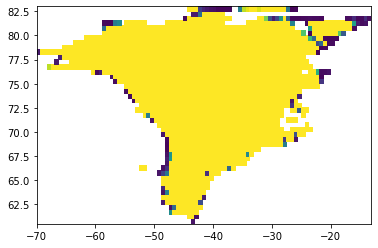

In [31]:
plt.pcolormesh(df_dec_90pct.columns.astype('float'),df_dec_90pct.index,df_dec_90pct.values,
               vmin=0,vmax=100)

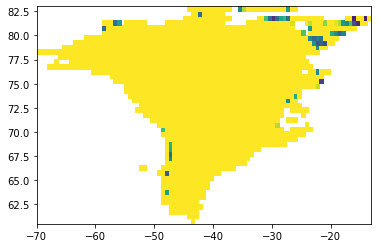

In [32]:
plt.pcolormesh(df_inc_90pct.columns.astype('float'),df_inc_90pct.index,df_inc_90pct.values,
               vmin=0,vmax=100)